This notebook demonstrates our final method for predicting energy generated in Southeast/Central West Brazil.  While many other standard models were considered--naive methods, many varieties of exponential smoothing--we ultimately settled on SARIMA type models because they gave us the best accuracy and allowed us to incorporate external regressors in a straightforwards manner.  

In [109]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates

#for decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# Exponential smoothing methods
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

# for time series cross validation
from sklearn.model_selection import TimeSeriesSplit

# used for autocorrelation and ARIMA/SARIMA
import statsmodels.api as sm

# for determining differencing in ARIMA models:
#statsmodels.tsa.stattools

# measuring MAE and RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# this controls warnings (which are sometimes annoying)
from warnings import catch_warnings
from warnings import filterwarnings

# Making parameter selection iteration look less nasty:
import itertools

# kpss
from statsmodels.tsa.stattools import kpss

# ggplot for residuals
import plotnine

import matplotlib as mpl
# 
from sklearn.impute import SimpleImputer

In [110]:
#Plotting preferences

# increase figure size
plt.rcParams['figure.figsize'] = [12, 8]
# increase plot text size
mpl.rc('font', size=15)

In [111]:
# toggle warnings

# turn warnings off when the code is working fine
filterwarnings("ignore")

# turn warnings back on when debugging
# warnings.filterwarnings("default")

In [112]:
#Importing data and cleaning to make a nice df with multiple columns

# import data (already cleaned on github)
df = pd.read_csv("./ts_data/energy_generated.csv")

#renaming the columns since old code was all lower case, want to reuse 
df.rename(columns={
        'Date': 'date', 
        'Energy_Generated': 'energy_generated'
    }, inplace=True)

# reads date as date
df['date'] = pd.to_datetime(df['date'],format = '%b-%y')  


# check for missing dates... seems there are none
print(pd.date_range(
  start="1999-01-01", end="2021-06-01", freq = 'MS').difference(df['date']))

# further data cleaning and adding exogenous variables

# adding a dummy variable for 2014 when the trend changes
df['2014?'] = np.array((df.date >= '2014-01-01'), np.int16)

#adding in rain data
rain_data = pd.read_csv("./ts_data/accumulate_rain_subsystem.csv")
rain_data['date'] = pd.to_datetime(rain_data['date'],format = '%Y-%m-%d')
df = pd.merge(df,rain_data, on = ['date'])
print(pd.date_range(
  start="2000-06-01", end="2020-12-01", freq = 'MS').difference(df['date'])) # check seems good

# influent flow and demand data (from 18 biggest)
dam_big_data = pd.read_csv("./ts_data/Selected_important_dams_energy_demand_flow_monthly.csv.zip")
# inf_flow_data = pd.read_csv("./InfluentFlow_Subsystem.csv")
dam_data = dam_big_data[['year', 'month', 'date', 'influent_flow', 'maximum_demand']]
dam_data = dam_data.groupby(['year', 'month']).mean()
dam_data['date'] = pd.date_range(
  start="2000-01-01", end="2019-12-01", freq = 'MS')
dam_data.index = dam_data.date
dam_data = dam_data.drop(['date'], axis = 1)
df = pd.merge(df,dam_data, on = ['date'])


# influent flow not aggregated
dam_data2 = pd.read_csv("./ts_data/Mean_Influent_Flow_per_Important_Dam.csv")
dam_data2['date'] = pd.to_datetime(dam_data2['date'],format = '%Y-%m-%d')
# dropping columns with many empty data
dam_data2.drop(axis=1, columns='BATALHA', inplace=True, errors='raise')
dam_data2.drop(axis=1, columns='SERRA DO FACAO', inplace=True, errors='raise')
dam_data2.drop(index = 167, axis = 0, inplace = True)
df = pd.merge(df,dam_data2, on = ['date'])


print(pd.date_range(start="2000-06-01", end="2019-12-01", freq = 'MS').difference(df['date']))

# printing information
df.head()
# df.info()

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


,date,energy_generated,2014?,date.1,year,month,Total_accumulate,influent_flow,maximum_demand,BARRA BONITA,...,ITUMBIARA (FURNAS),MAL. MASCARENHAS DE MORAES,MARIMBONDO,NOVA PONTE,PARAIBUNA,SAO SIMAO (CEMIG),SEN. JOSE ERMIRIO DE MORAES,SERRA DA MESA,TRES IRMAOS,TRES MARIAS
0,2000-06-01,27449.69931,0,2000-06-01,2000,6,438.51,1681.059644,1018563.0,167.178667,...,1336.000000,885.860000,1593.304333,162.566667,35.801667,2259.866667,1901.948333,296.932000,784.113333,279.633333
1,2000-07-01,26911.89530,0,2000-07-01,2000,7,1226.07,1622.057527,1041282.0,204.750000,...,1143.903226,860.081935,1442.666129,136.451613,36.459032,2171.032258,1842.405161,219.641290,588.710000,201.838710
2,2000-08-01,27484.42137,0,2000-08-01,2000,8,1879.60,1590.026495,1049196.2,199.782903,...,1229.101290,970.673226,1371.359677,103.903226,36.862903,2224.516129,1807.384194,157.278710,606.330968,143.387097
3,2000-09-01,26949.43965,0,2000-09-01,2000,9,4350.47,1776.302644,1004104.9,343.841333,...,929.300000,850.133333,1452.323000,157.266667,54.308000,2100.866667,1506.026667,172.464667,737.184667,223.300000
4,2000-10-01,26815.92367,0,2000-10-01,2000,10,2472.91,1625.567178,990403.6,191.795161,...,1079.021613,929.791935,1196.667097,89.774194,36.792258,2231.290323,1781.995484,136.140000,716.715484,98.419355


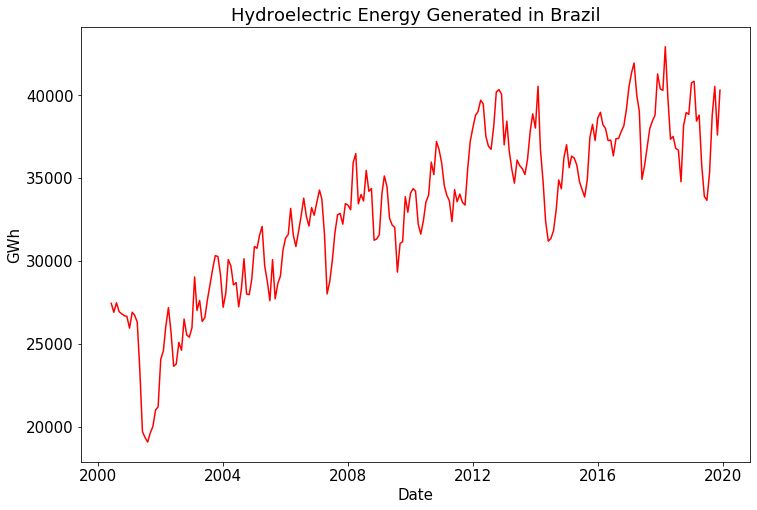

In [113]:
#plotting energy generated over full time period
plt.plot(df.date[:], df.energy_generated[:], 'r')   
plt.title('Hydroelectric Energy Generated in Brazil')
# Units not in GWh
plt.ylabel('GWh');
plt.xlabel('Date');
plt.show();

Now that we have plotted the data, we are going to start making predictions.  

We will give the mean error of each prediction $n$ months in advance after cross validating 12 times.  That is, for $n \in \{1,2,\cdots\, 12\}$, we will make a prediction for energy generated $n$ months from now, and use time series cross validation so that we make that prediction 12 times.  

The following function will choose optimal parameters for the SARIMA model based on minimizing the AIC on a training set that ignores the last 24 months (so that we don't test on any training data).

Exogenous variables may be included in the selection by changing the $x$ variable in the next cell.  We will later use standard SARIMA models in order to predict these exogenous regressors so that they may be included in our SARIMA model for energy generation and still have a true prediction.  


In [131]:
# Parameter selection and Exogenous regressor selection

# number of cross validations (in case we want to change, probably shouldn't)
cross_splits = 24
# how many months are we going to check (Ivan wants 12)
tot_months = 12
# seasonality parameter is known (12 for monthly data)
m = 12

# exogenous regressor selection
x = None
# x = df[['influent_flow']].copy()
# x = df[['Total_accumulate']].copy()
# x = df[['maximum_demand']].copy()
# x = df[['maximum_demand','influent_flow']].copy()
# x = df[['BARRA BONITA',
#        'CHAVANTES', 'COMPLEXO ILHA SOLTEIRA', 'EMBORCACAO', 'FURNAS', 'ITAIPU',
#        'ITUMBIARA (FURNAS)', 'MAL. MASCARENHAS DE MORAES', 'MARIMBONDO',
#        'NOVA PONTE', 'PARAIBUNA', 'SAO SIMAO (CEMIG)',
#        'SEN. JOSE ERMIRIO DE MORAES', 'SERRA DA MESA', 'TRES IRMAOS',
#        'TRES MARIAS']].copy()

# this one takes all of our external regressors--accumulated rainfall, maximum demand (from ONS), and influent flow at 15 dams in the region
# x = df[['Total_accumulate','maximum_demand', 'BARRA BONITA',
#        'CHAVANTES', 'COMPLEXO ILHA SOLTEIRA', 'EMBORCACAO', 'FURNAS', 'ITAIPU',
#        'ITUMBIARA (FURNAS)', 'MAL. MASCARENHAS DE MORAES', 'MARIMBONDO',
#        'NOVA PONTE', 'PARAIBUNA', 'SAO SIMAO (CEMIG)',
#        'SEN. JOSE ERMIRIO DE MORAES', 'SERRA DA MESA', 'TRES IRMAOS',
#        'TRES MARIAS']].copy()

# removing test data for the parameter selection.  
# we can improve the model if we are willing to run computational time longer
df_param_selector = df.iloc[:-(cross_splits+tot_months),:].copy()

# setting aside exogeneous for parameter selection
if x is None:
    x_param_sel = None
else:
    x_param_sel = x.iloc[:-(cross_splits+tot_months),:].copy()

In [132]:
# build some other functions for KPSS testing and determining d parameter in SARIMA

# difference function 
def difference_fct(timeseries):
    '''
    input: 1-d arraylike? object
    output: the difference 
    '''
    diff_series = timeseries.copy()
    for n in range(len(timeseries)):
        if n != 0:
            diff_series[n] = timeseries[n] - timeseries[n-1]
        else:
            pass
    diff_series.drop(index=diff_series.index[0],axis=0, inplace=True)
    diff_series.index = np.arange(len(diff_series))    
    return diff_series

# determine d in ARIMA 
def d_detector(timeseries):
    '''
    determines what the value of d should be in an ARIMA model
    input: 1-d arraylike? object
    output: how many differences do we need to do till we are stationary
    '''
    n = 0
    while kpss(timeseries)[1] < 0.05:
        timeseries = difference_fct(timeseries)
        n += 1
    
    return n

# seasonal_difference function

def diff_series_seas(timeseries, seas_len):
    '''
    computes seasonal difference
    input: 
        timeseries: 1-dim arraylike? object
        seas_len: integer, length of season (i.e. 12 for monthly data)
    output: 1-dim arraylike? object of length len(timeseries) - seas_len
    '''
    
    diff_series = timeseries.copy()
    
    listo = [i for i in range(0,len(timeseries)) if i not in range(0,seas_len)]

    for n in listo:
        diff_series[n] = timeseries[n] - timeseries[n-seas_len]
    
    diff_series.drop(index=diff_series.index[range(0,seas_len)],axis=0, inplace=True)
    diff_series.index = np.arange(len(diff_series)) 
    
    return diff_series

# determine D in SARIMA

def d_det_seas(timeseries, seas_len):
    '''
    determines what the value of d should be in a SARIMA model
    Will max out at D = 1
    input: 
        timeseries: 1-dim arraylike? object
        seas_len: integer, length of season (i.e. 12 for monthly data)
    output: appropriate D and d for seasonal data (max D = 1)
    '''
    timeseries = diff_series_seas(timeseries, seas_len)
    
    d = 0
    
    while kpss(timeseries)[1] < 0.1:
        timeseries = difference_fct(timeseries)
        d += 1
    
    return d

In [133]:
# best parameters for the main model

# using built-in function to create all possible parameter values
# (p,q,P,Q)
# # commented out most of the time because this algorithm is slooooooowwwwww

# tests in other notebooks determined that data is seasonal, period 12
D = 1
d = d_det_seas(df_param_selector['energy_generated'], m)

param_set = itertools.product([0,1,2],[d],[0,1,2],[0,1,2],[D],[0,1,2])

# extracting the column we need
nrg_gen = df_param_selector['energy_generated']

# list of top 5 AIC initialized
# starting values chosen to be ridiculously high so that the AIC values we replace with are always lower
aic_list = [500000000000,500000000000.1,500000000000.2,500000000000.3,500000000000.4]

# initialize a dictionary of best parameters:
best_param_dict = {aic_list[0]: [],
                   aic_list[1]: [],
                   aic_list[2]: [],
                   aic_list[3]: [],
                   aic_list[4]: []}

for p,d,q,P,D,Q in param_set:  
    # need try because sometimes things don't converge fast enough and we get runtime errors
    try:
        # never show warnings when grid searching, too noisy
        with catch_warnings():
            filterwarnings("ignore")
            mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x_param_sel, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
            res = mod.fit(disp=False)
    except:
        pass
    # the restriction res.aic > 1500 is to rule out models that ended up overfit
    if (res.aic < np.min(aic_list)) & (res.aic > 1500):
        del best_param_dict[max(aic_list)]
        best_param_dict[res.aic]=[p,d,q,P,D,Q]
        aic_list=list(best_param_dict.keys())
    
[p_nrg,d_nrg,q_nrg,P_nrg,D_nrg,Q_nrg] = best_param_dict[np.min(list(best_param_dict.keys()))]


In [135]:
# best parameters for SARMIA predictions of exogenous regressors

if x is None:
    pass
else:
    # we are assuming that the data is seasonal, period m=12
    # this could use further analysis for these regressors--ran against time limit
    # probably true, though, since they're all related to weather and demand
    D = 1

    # df of parameter values--each entry will be the (pdqPDQ) for one of the exogenous regressors (initalized by zeros)
    exog_param_df = pd.DataFrame(0, index=np.arange(6), columns=x.columns)

    for col in x.columns:
        d = d_det_seas(x_param_sel[col], m)
        param_set = itertools.product([0,1,2],[d],[0,1,2],[0,1,2],[D],[0,1,2])
        
        # list of top 5 AIC initialized
        # starting values chosen to be ridiculously high so that the AIC values we replace with are always lower
        aic_list = [500000000000,500000000000.1,500000000000.2,500000000000.3,500000000000.4]

        # initialize a dictionary of best parameters:
        best_param_dictX = {aic_list[0]: [],
                           aic_list[1]: [],
                           aic_list[2]: [],
                           aic_list[3]: [],
                           aic_list[4]: []}

        for p,d,q,P,D,Q in param_set:  
            # need try because sometimes linalg won't converge fast enough and we get runtime errors
            try:
                # never show warnings with this algorithm, too noisy
                with catch_warnings():
                    filterwarnings("ignore")
                    mod = sm.tsa.statespace.SARIMAX(x_param_sel[col], order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
                    res = mod.fit(disp=False)
            except:
                pass
            # the restriction res.aic > 1500 is to rule out models that ended up overfit
            if (res.aic < np.min(aic_list)) & (res.aic > 1500):
                del best_param_dictX[max(aic_list)]
                best_param_dictX[res.aic]=[p,d,q,P,D,Q]
                aic_list=list(best_param_dictX.keys())
        exog_param_df[col] = best_param_dictX[np.min(list(best_param_dictX.keys()))]

In the previous cell, parameters are automatically set by selecting the minimum AIC.  However, the best_param_dict dictionary has several other possible parameter choices.  We can examine the residuals and determine if they are mean zero, stationary, etc.  This is done in the following cells.

Note that best_param_dict is for the main variable (energy generated).  Similar functionality is built into best_param_dictX for a single exogenous variable, but the code is not quite as robust for multiple exogenous regressors; while the minimum found AIC is stored for all regressors, only the last one will provide a full dictionary.  Again, time constraints.

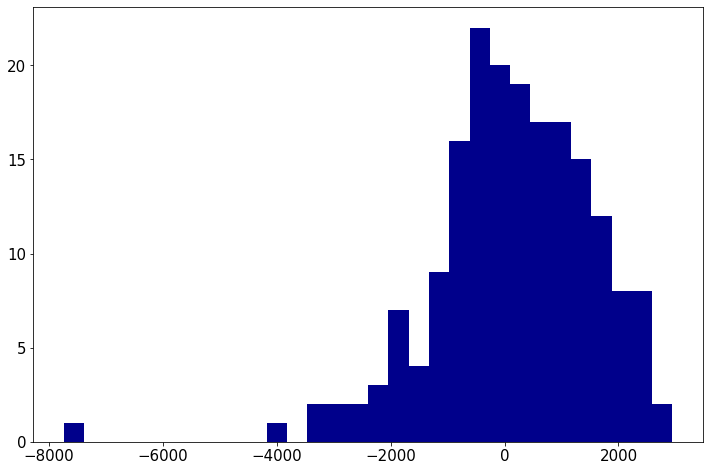

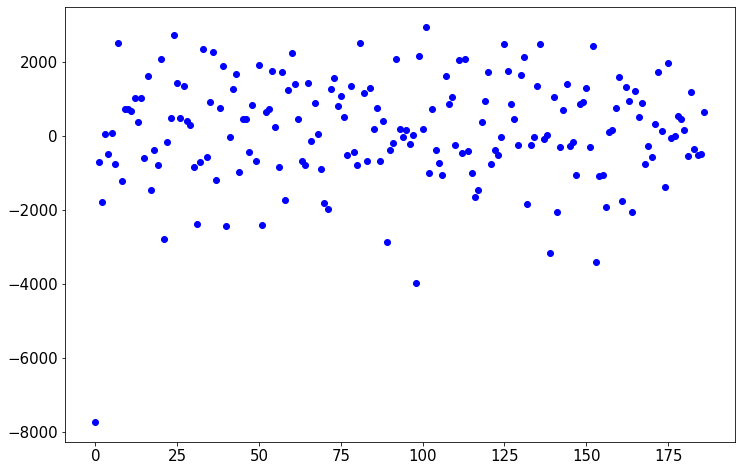

140.44539651915105


In [136]:
# plotting residuals

nrg_gen = df_param_selector['energy_generated']

# changing the index here (0 through 4) gives us 5 options of possible parameters to check
# [p,d,q,P,D,Q] = best_param_dict[list(best_param_dict.keys())[4]]
# the lowest AIC for energy generation prediction
[p,d,q,P,D,Q] = [p_nrg,d_nrg,q_nrg,P_nrg,D_nrg,Q_nrg]
# alternatively, for code testing when we don't want to spend 10 mins running grid search; parameters arbitrary
# [p,d,q,P,D,Q] = [1,1,0,0,1,0]
# [p,d,q,P,D,Q] = [1,0,0,0,1,0]



# building the model
mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x_param_sel, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
res = mod.fit(disp=False)

# plot histogram of residuals
plt.hist(res.forecasts_error[0], bins = 30, color = 'darkblue')
plt.show()

# view residuals as functions of time
plt.plot(res.forecasts_error[0], 'bo')
plt.show()

# checking mean of the residuals (hope for close to 0)
print(np.mean(res.forecasts_error[0]))

Having selected parameters--either automatically through above algorithm, or more preferably by some analysis of the residuals--we now perform a cross validation in order to assess the accuracy of our model.  Note that the cross validation here is not choosing any parameters, but only attempting to get a more realistic view of the accuracy of our model.  

At the moment, accuracy is determined by the following formula:
$$\frac{100}{n}\sum_{i=1}^n\frac{|\hat{y}_i - y_i|}{y_i}$$
where $n$ is the number of cross validation splits we used.  That is, MAPE.

More specifically, the  cross validation works by checking each k month prediction as many times as we set the splits above.  In the current version of the code, we took 12 splits, and so each k month prediction happens 12 times, meaning each k month prediction looks at our ability to predict k months in advance while starting every month in the year.  Thus the mean in the MAPE above is taken by averaging the errors obtained by predicting January k months in advance, Febuary k months in advance,..., December k months in advance.  


In [137]:
# cross validation of SARIMA (allowing for exog)
# this takes a long time if we are using many regressors because we have to run a SARIMA model in order to predict each regressor at each step
# I think that this algorithm is computationally inefficient--I am doing the same SARIMA regressor predictions multiple times

# initializing a list to store CV error
CVerr_list = [0]*cross_splits
# initializing list of absolute percent error (reset each round)
per_err_list = [0]*cross_splits

# main variable for SARIMA
nrg_gen = df['energy_generated'].copy()

# need a for loop so we can get accuracy of (n+1) months out for n 0-11:
for n in range(0,tot_months):
    # notice that gap is how many months between.  So n=0 corresponds to next month
    tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = 1, gap = n)
    # counter to put in list
    i = 0
    # for loop so that we can test over all of our cross validation splits
    for train_index, test_index in tscv.split(nrg_gen):
        y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
        # must predict each regressor if exog is not None
        if x is not None:  
            # training data for SARIMA is straightforward
            x_train = x.iloc[train_index]
            # test input of exogenous regressors is not straightforward
            # create an array zeros which will be used to stores test exogs
            top_train = max(train_index)
            test_num = min(test_index)
            x_test_index = np.linspace(top_train + 1, test_num, test_num-top_train).astype(int)
            x_test = pd.DataFrame(0, index=x_test_index, columns=x.columns)
            # need to predict each column with a SARIMA model
            for col in x.columns:
                [p,d,q,P,D,Q] = exog_param_df[col]
                fitX =sm.tsa.statespace.SARIMAX(endog=x_train[col], order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
                fcastX = fitX.forecast(n+1)
                x_test[col] = fcastX
        # no exog is easy
        else:
            x_train, x_test = None, None
        # SARIMA
        fit =sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, order=(p_nrg, d_nrg,q_nrg),seasonal_order=(P_nrg,D_nrg,Q_nrg,m)).fit()
        fcast = fit.forecast(n+1, exog = x_test)
        # printing parameters and MAE
        per_err = 100*(list(fcast)[-1] - y_test)/y_test
        per_err_list[i] = per_err
        i += 1
    CVerr_list[n] = per_err_list.copy()
    print('The CV MAPE of a prediction %s months in advance ' %(n+1), 'is %s' %np.mean(np.abs(CVerr_list[n])))

The CV MAPE of a prediction 1 months in advance  is 3.8411738197357437
The CV MAPE of a prediction 2 months in advance  is 4.052369896791596
The CV MAPE of a prediction 3 months in advance  is 3.278005775157512
The CV MAPE of a prediction 4 months in advance  is 3.58301281297768
The CV MAPE of a prediction 5 months in advance  is 3.801744687389087
The CV MAPE of a prediction 6 months in advance  is 3.778864095800625
The CV MAPE of a prediction 7 months in advance  is 3.7472478220637497
The CV MAPE of a prediction 8 months in advance  is 3.740293388683972
The CV MAPE of a prediction 9 months in advance  is 3.808590171213998
The CV MAPE of a prediction 10 months in advance  is 3.758787987424848
The CV MAPE of a prediction 11 months in advance  is 3.7481635542752443
The CV MAPE of a prediction 12 months in advance  is 3.784730893172586


We now plot the results of our prediction.  When there are no exogenous regressors we give a 95% confidence band.  However, when we incorporate exogenous regressors, giving such a band would be very difficult--we must compound the errors of the SARIMA predictions of the regressors and the errors of the final SARIMA predictions.  That adds a large layer of complexity which we cannot address because of time constraints.  

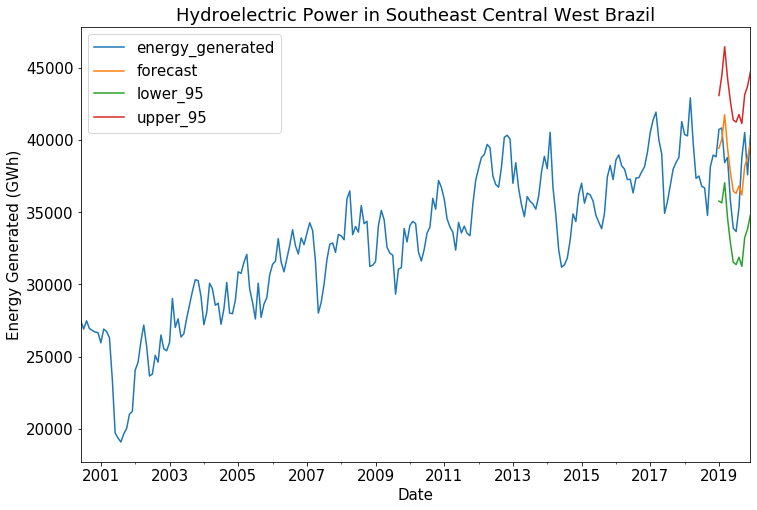

In [138]:
# Plotting results of SARIMA with exogenous variables

df_new = df.copy()
nrg_gen = df_new['energy_generated'][:-tot_months]

if x is None:
    model=sm.tsa.statespace.SARIMAX(nrg_gen,  order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = results.predict(start = len(nrg_gen), end = len(nrg_gen)+tot_months, dynamic = False)
    # 95% confidence interval: https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/
    forecast_info = results.get_forecast(12)
    a = 0.05
    ci = forecast_info.conf_int(alpha = a)
    df_new['lower_95'] = ci['lower energy_generated']
    df_new['upper_95'] = ci['upper energy_generated']
    # plotting
    df_new.set_index('date', inplace = True)
    df_new[['energy_generated','forecast','lower_95','upper_95']].plot(figsize=(12,8))
    plt.title('Hydroelectric Power in Southeast Central West Brazil')
    plt.ylabel('Energy Generated (GWh)');
    plt.xlabel('Date');
    plt.savefig('foo.png')
    plt.show()
else: 
    x_train = x.iloc[:-tot_months]
    # building test exog for plotting
    x_test = x.iloc[-tot_months:]
    for col in x.columns:
        [p,d,q,P,D,Q] = exog_param_df[col]
        fitX =sm.tsa.statespace.SARIMAX(endog=x_train[col], order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
        fcastX = fitX.forecast(tot_months)
        x_test[col] = fcastX
    model=sm.tsa.statespace.SARIMAX(nrg_gen, exog = x_train, order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = np.nan
    fcast = results.forecast(tot_months, exog = x_test)
    df_new['forecast'][-tot_months:] = fcast
    # plotting
    df_new.set_index('date', inplace = True)
    df_new[['energy_generated','forecast']].plot(figsize=(12,8))
    plt.title('Hydroelectric Power in Southeast Central West Brazil')
    plt.ylabel('Energy Generated (GWh)');
    plt.xlabel('Date');
    plt.savefig('foo.png')
    plt.show()

There is an inherent danger to measuring accuracy by MAPE (or any other single measurement).  It is possible that we may obtain relatively good predictive accurary overall, but be consistantly predicting one of the months incorrectly (perhaps this model is very good at predicting energy in the summer but not the winter, or something like that).  Therefore we will also give a plot of the errors in each month in order to check the seasonality of our errors.  

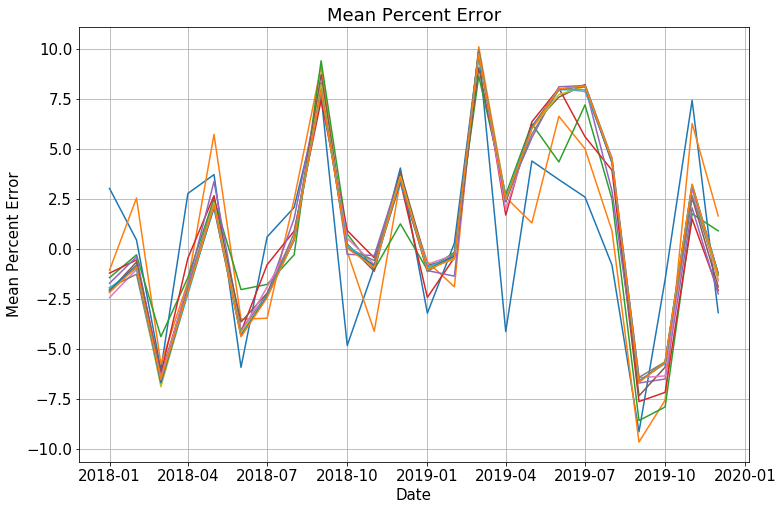

In [139]:
# note that date_list is not a robust part of the code.  If we change parameters earlier (choosing to CV over something other than 24 splits, for instance), these dates will be wrong.  Ran out of time to fix this small issue
date_list = pd.date_range(start="2018-01-01", end="2019-12-01", freq = 'MS')

for n in range(0,tot_months):
    plt.plot(date_list, list(CVerr_list[n])) #the label won't work, I have no idea why

plt.title('Mean Percent Error')
plt.ylabel('Mean Percent Error');
plt.xlabel('Date');
plt.grid(b = True)

plt.savefig('error_plot.png')
plt.show()